# Solar Activity

Solar activity is determined by the **number of sunspots**. Sunspots are dark areas on the Sun's photosphere. They appear darker because they have temperature lower than surrounding areas (surface temperature is 5800K while sunspots' temperature varies from 3000 to 4500 K.

Sunspots are formed due to the Sun's magnetic activity, which is caused by **differential rotation**. It means that angular velocity differs depending in the latitude - the closer to it is to the equator the faster it moves. The result is a stretching magnetic field that spontaneously reconnects, creating cooler areas.

The differential rotation also causes a Solar Cycle - 11 Year period where number of sunspots increases and decreases. In this presentation we will try to extract some information based on the number of sunspots in each month and year since 18th century.

In [239]:
import sys
sys.path.append('..')

In [240]:
import itertools
import pandas as pd
import numpy as np
from astropy.timeseries import LombScargle
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from scipy.signal import find_peaks
from pmdarima import auto_arima
from matplotlib import image as mpimg
from CommonFunctions import *
%matplotlib inline

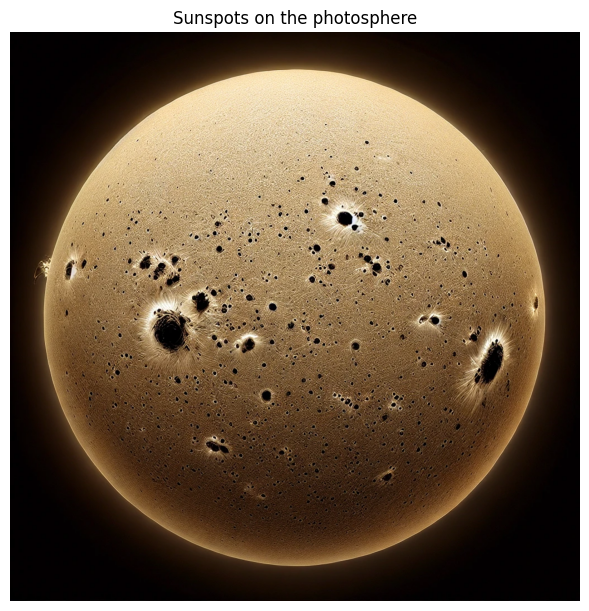

In [241]:
figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(6, 6))
axes.imshow(mpimg.imread('./images/sun.png'))
axes.set_title('Sunspots on the photosphere')
axes.axis(False);

In [242]:
dataset_year = pd.read_csv('./data/Yearly.csv', sep= ';', usecols=[0, 1], header=None)
dataset_year.columns = ['Year', 'Sunspots']
dataset_year.index = pd.to_datetime(dataset_year.Year, format='%Y')
dataset_year.drop(columns=['Year'], inplace=True, axis=1)
dataset_month = pd.read_csv('./data/13monthSmoothed.csv', sep=';', usecols=[0, 1, 3], header=None)
dataset_month.columns = ['Year', 'Month', 'Sunspots']
dataset_month.index = pd.to_datetime(
    dataset_month.Year.astype(str) + '-' + dataset_month.Month.astype(str), format='%Y-%m')
dataset_month.drop(columns=['Year', 'Month'], inplace=True, axis=1)
dataset_month.replace(to_replace=-1., value=float('nan'), inplace=True)
dataset_month.dropna(inplace=True)

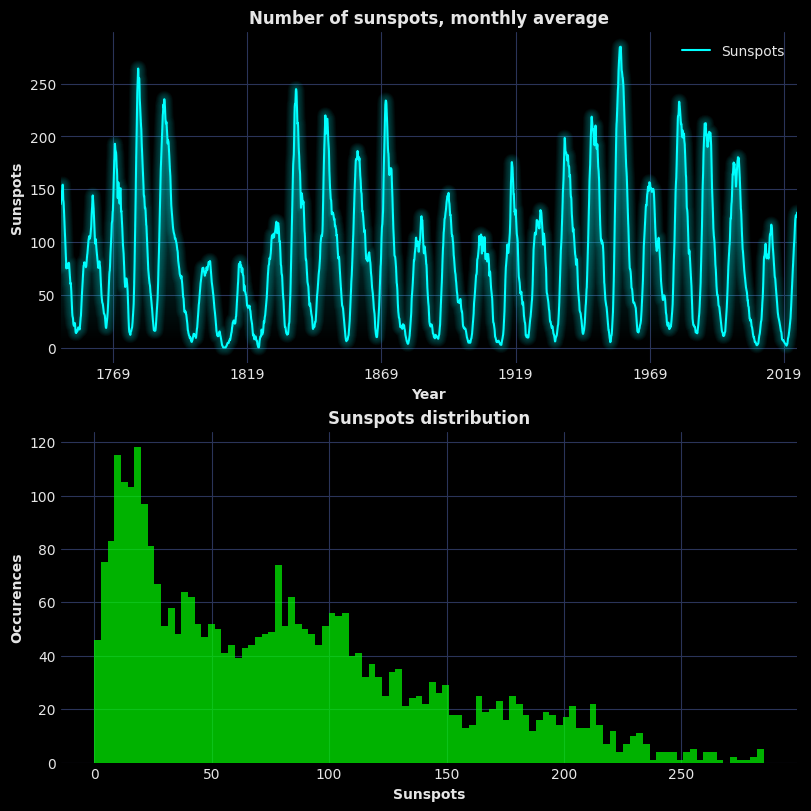

In [243]:
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(2, 1, layout='constrained', figsize=(8, 8))
    dataset_month.plot(ax=axes[0], color='cyan')
    axes[0].set(title='Number of sunspots, monthly average', xlabel='Year', ylabel='Sunspots')
    enhance_plot(figure, axes[0], glow=True, alpha_gradient=0.5)
    axes[1].hist(dataset_month.Sunspots.values, bins=100, color='lime', alpha=0.7, align='mid')
    axes[1].set(xlabel='Sunspots', ylabel='Occurences', title='Sunspots distribution')
    enhance_plot(figure, axes[1])
figure.savefig('./images/image1.png')

# Estimating Frequency
By monthly data we expect approximately 132 month period (11 years). We use 2 methods:
* Using Lomb-Scargle Periodogram to estimate frequency
* Autocorrelation function (for this one we use yearly data)

Lomb-Scargle periodogram is a tool that estimates the power spectral density PSD of a signal. It is more sophisticated because it allows to find periodicities in unevenly spaced data.

Dominant period: 132.42156074014483 months


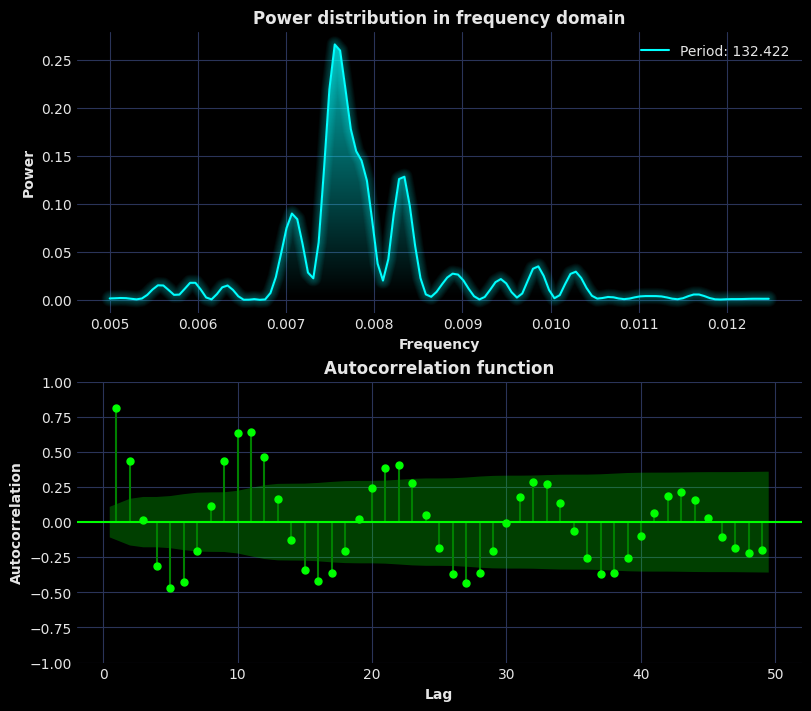

In [244]:
frequency, power = LombScargle(
    np.arange(len(dataset_month)),
    dataset_month.Sunspots.values
).autopower(minimum_frequency=1/200, maximum_frequency=1/80)
dominant_frequency = frequency[np.argmax(power)]
dominant_period_months = 1 / dominant_frequency
print(f"Dominant period: {dominant_period_months} months")
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(2, 1, layout='constrained', figsize=(8, 7))
    axes[0].plot(frequency, power, color='cyan', label=f'Period: {dominant_period_months:.3f}')
    axes[0].set(xlabel='Frequency', ylabel='Power', title='Power distribution in frequency domain')
    axes[0].legend()
    enhance_plot(figure, axes[0], glow=True, alpha_gradient=0.7)
    plot_acf(dataset_year, ax=axes[1], color='lime', lags=range(1, 50), vlines_kwargs=dict(color='green'), title=None)
    set_polygon_color(axes[1], color='lime')
    axes[1].set(xlabel='Lag', ylabel='Autocorrelation', title='Autocorrelation function')
    enhance_plot(figure, axes[1])
figure.savefig('./images/image2.png')

# Monthly average decomposition

* Trend
* Seasonality
* Residuals

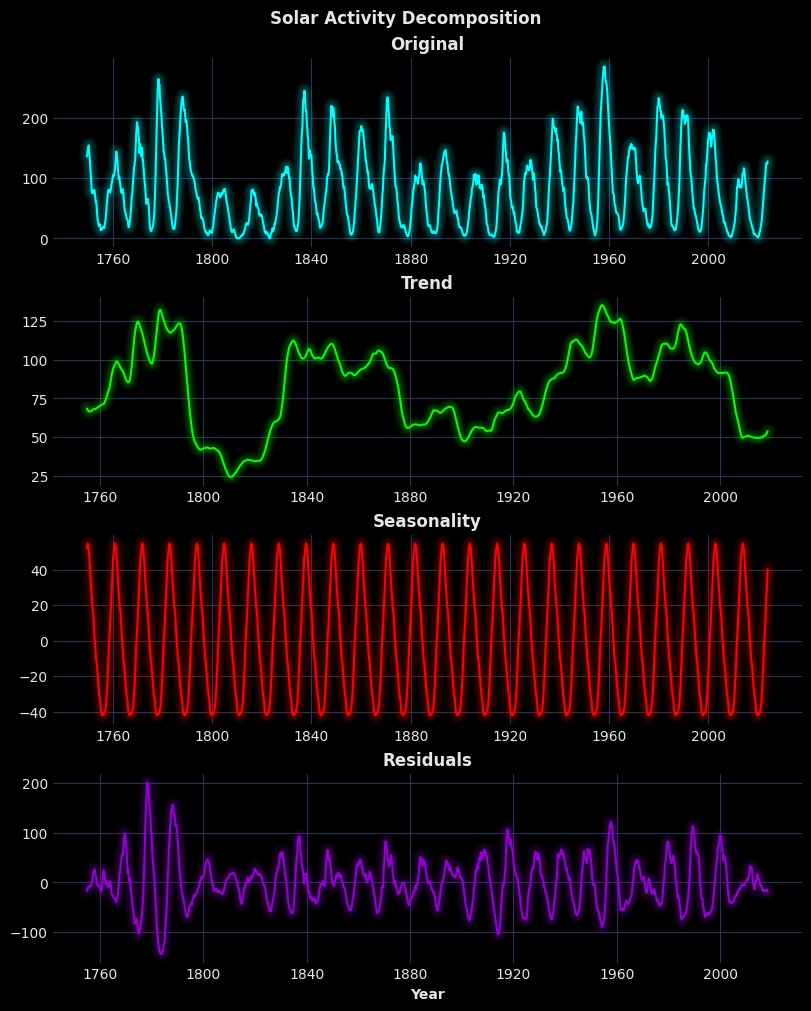

In [245]:
decomposition = seasonal_decompose(dataset_month.Sunspots, 
                                   model='additive', period=round(dominant_period_months))
decomposition_year = seasonal_decompose(dataset_year.Sunspots,
                                        model='additive', period=11)
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(4, 1, layout='constrained', figsize=(8, 10))
    axes[0].plot(dataset_month, color='cyan')
    axes[1].plot(decomposition.trend, color='lime')
    axes[2].plot(decomposition.seasonal, color='red')
    axes[3].plot(decomposition.resid, color='darkviolet')
    for ax, name in zip(figure.axes, ['Original', 'Trend', 'Seasonality', 'Residuals']):
        ax.set(title=name)
        enhance_plot(figure, ax, glow=True)
    axes[-1].set(xlabel='Year')
    figure.suptitle('Solar Activity Decomposition', fontweight='bold')
figure.savefig('./images/image3.png')

# Differencing

We now use other methods of decomposing a time series of yearly data:
* First-Order differencing
* 11-Year differencing
* Combined differencing

We also conduct a Ljung-Box Test to check for any dependence

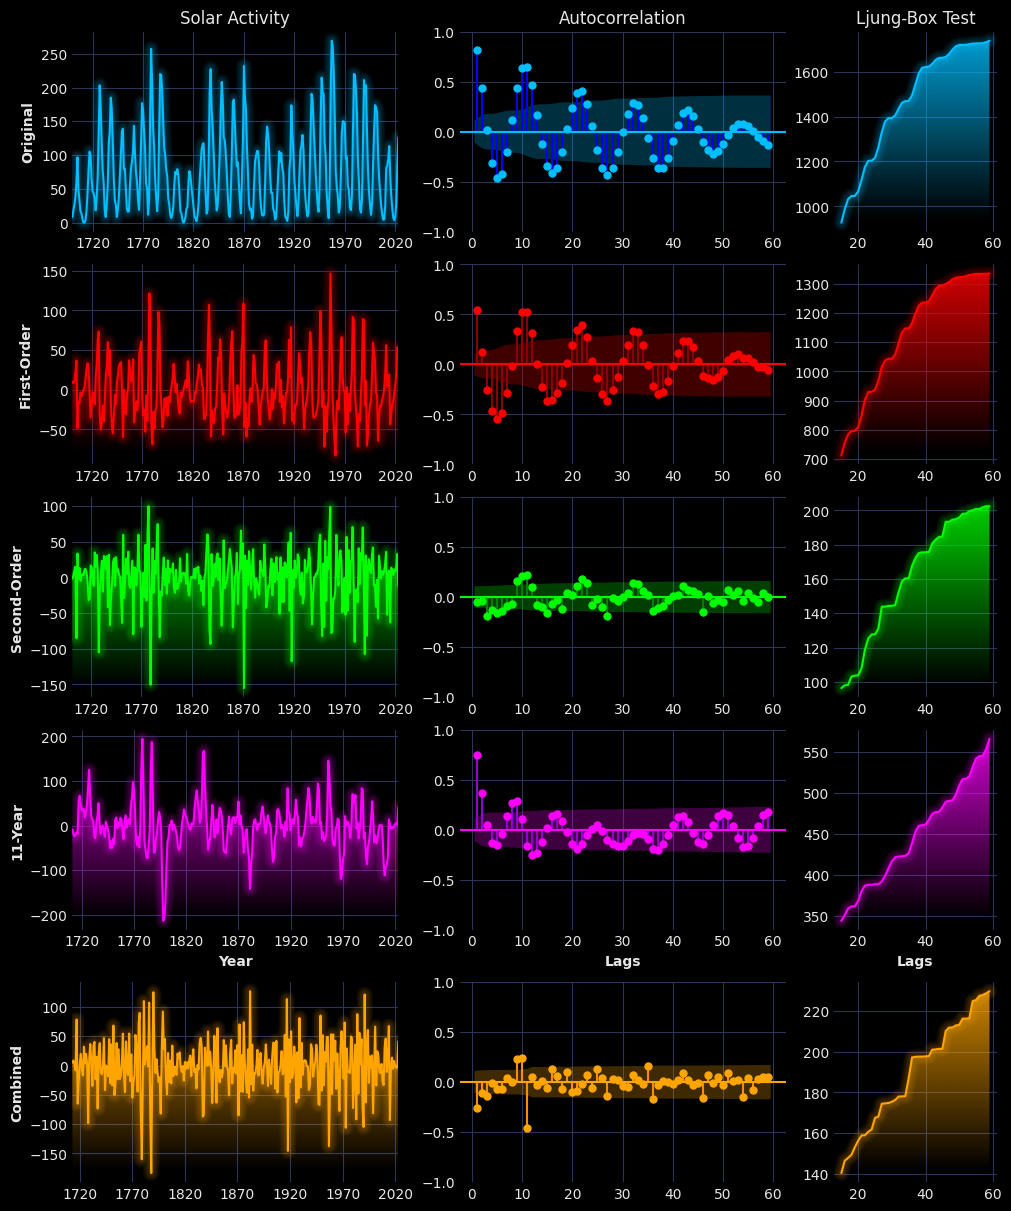

In [246]:
dataset_year_diff = dataset_year.diff().dropna()
dataset_year_diff2 = dataset_year_diff.diff().dropna()
dataset_year_seasonal_diff = dataset_year.diff(periods=int(dominant_period_months / 12)).dropna()
dataset_year_combined = dataset_year_seasonal_diff.diff().diff().dropna()

max_lag = 60
colors = [('blue', 'deepskyblue'), ('darkred', 'red'), 
          ('green', 'lime'), ('darkviolet', 'fuchsia'), ('darkorange', 'orange')]
titles = ['Original', 'First-Order', 'Second-Order', '11-Year', 'Combined']
series_list = [dataset_year, dataset_year_diff, dataset_year_diff2,
               dataset_year_seasonal_diff, dataset_year_combined]
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(5, 3, layout='constrained', figsize=(10, 12), width_ratios=[2, 2, 1])
    for index, (series, title, (_, color)) in enumerate(zip(series_list, titles, colors)):
        series.plot(ax=axes[index, 0], color=color, legend=False)
        axes[index, 0].set(ylabel=title, xlabel=None)
        enhance_plot(figure, axes[index, 0], glow=True, alpha_gradient=0.8)
    axes[0, 0].set_title('Solar Activity')
    axes[4, 0].set(xlabel='Year')
    for index, (series, (bg_color, color)) in enumerate(zip(series_list, colors)):
        plot_acf(series, ax=axes[index, 1], lags=range(1, max_lag), color=color,
                 vlines_kwargs=dict(color=bg_color), title=None)
        set_polygon_color(axes[index, 1], color)
        enhance_plot(figure, axes[index, 1])
    axes[0, 1].set(title='Autocorrelation')
    axes[4, 1].set(xlabel='Lags')
    for index, (series, (_, color)) in enumerate(zip(series_list, colors)):
        acorr_ljungbox(series, lags=range(15, max_lag), return_df=True)\
        .lb_stat.plot(ax=axes[index, 2], color=color)
        enhance_plot(figure, axes[index, 2], glow=True, alpha_gradient=0.8)
    axes[0, 2].set(title='Ljung-Box Test')
    axes[4, 2].set(xlabel='Lags')
figure.savefig('./images/image4.png')

## Let's now compare residuals from both methods

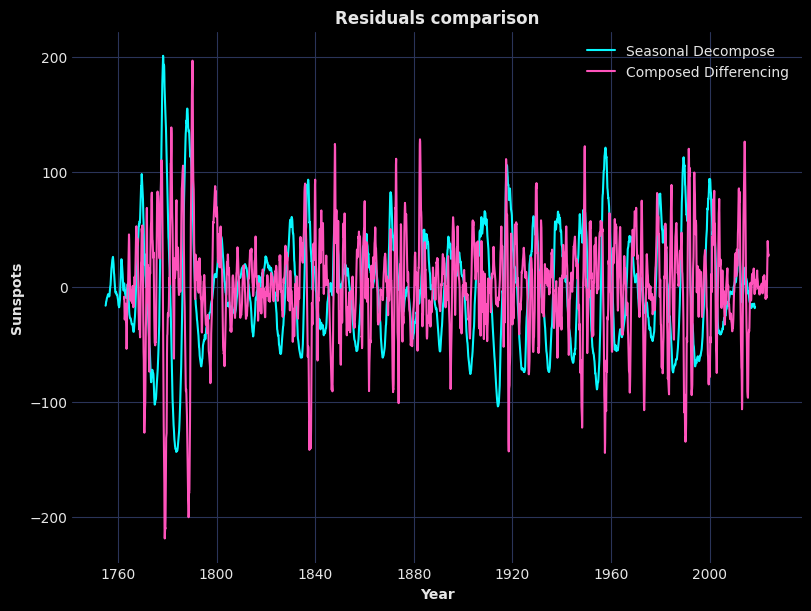

In [247]:
dataset_month_combined = (dataset_month.diff(periods=12).diff(periods=12)
                          .diff(periods=int(dominant_period_months)))
dataset_month_diff = dataset_month.diff(periods=12)
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 6))
    axes.plot(decomposition.resid, label='Seasonal Decompose')
    axes.plot(dataset_month_combined, label='Composed Differencing')
    axes.set(xlabel='Year', ylabel='Sunspots', title='Residuals comparison')
    axes.legend()
    enhance_plot(figure, axes)
figure.savefig('./images/image5.png')

## Checking stationarity with Augmented Dickey-Fuller test

In [248]:
for series, name in zip(series_list, titles):
    print(f'Type: {name}, Test result: {adfuller(series)[:2]}')

Type: Original, Test result: (-3.208803115915698, 0.019480741683491804)
Type: First-Order, Test result: (-14.985717412063408, 1.1446614280608457e-27)
Type: Second-Order, Test result: (-11.614095612555722, 2.4727742853957012e-21)
Type: 11-Year, Test result: (-4.566676530509803, 0.00014872425268751672)
Type: Combined, Test result: (-9.278985332272876, 1.2661342447290816e-15)


First-order differencing works the best with reducing stationarity

# Extracting a trend in sunspot peaks

* We use function *find_peaks* to achieve it
* We apply exponential smoothing to make it less sharp

In [249]:
def exponential_smoothing(data, alpha):
    predictions = np.array([])
    for index, t in enumerate(data):
        if index == 0:
            predictions = np.zeros(len(data))
            predictions[index] = data.item(index)
        else:
            predictions[index] = alpha * data.item(index) + (1 - alpha) * predictions.item(index - 1)
    return predictions

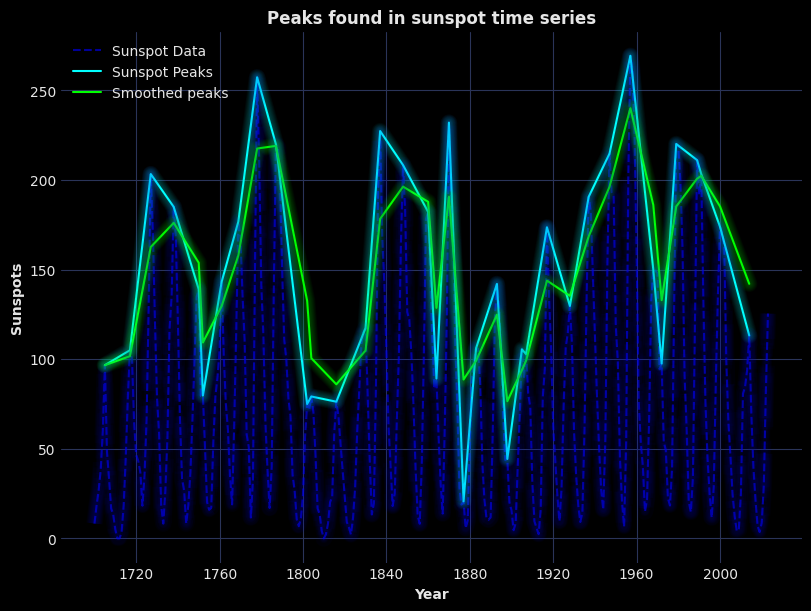

In [250]:
peaks, _ = find_peaks(dataset_year.Sunspots.values)
smoothed_peaks = exponential_smoothing(dataset_year.iloc[peaks].values, alpha=0.6)
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(1, 1, layout='constrained', figsize=(8, 6))
    axes.plot(dataset_year, color='blue', linestyle='--', label='Sunspot Data', alpha=0.6)
    axes.plot(dataset_year.iloc[peaks], color='cyan', label='Sunspot Peaks')
    axes.plot(dataset_year.index[peaks], smoothed_peaks, color='lime', label='Smoothed peaks')
    axes.set(xlabel='Year', ylabel='Sunspots', title='Peaks found in sunspot time series')
    axes.legend()
    enhance_plot(figure, axes, glow=True)
figure.savefig('./images/image6.png')

## Applying SARIMA models to Residuals and Differenced Time Series

In [251]:
# residuals
auto_arima(decomposition_year.resid.dropna(), trace=False, seasonal=True, m=11)

ARIMA(order=(0, 0, 3), scoring_args={}, seasonal_order=(1, 0, 0, 11),
      suppress_warnings=True, with_intercept=False)

In [252]:
# first-order
auto_arima(dataset_year_diff, trace=False, seasonal=True, m=11)

ARIMA(order=(5, 0, 0), scoring_args={}, seasonal_order=(1, 0, 1, 11),
      suppress_warnings=True, with_intercept=False)

In [253]:
# combined
auto_arima(dataset_year_combined, trace=False, seasonal=True, m=11)

ARIMA(order=(5, 0, 0), scoring_args={}, seasonal_order=(2, 0, 0, 11),
      suppress_warnings=True, with_intercept=False)

In [254]:
sarimax_predictions = {}
test_cycles = 3
for dataset, name, order in zip(
        [decomposition_year.resid.dropna(), dataset_year_diff, dataset_year_combined],
        ['Decomposition', '1-Order', 'Combined'],
        [((0, 0, 3), (1, 0, 0, 11)), ((5, 0, 0), (1, 0, 1, 11)), ((5, 0, 0), (2, 0, 0, 11))]):
    train = dataset.iloc[:-11 * test_cycles]
    test = dataset.iloc[-11 * test_cycles:]
    model = SARIMAX(train, order=order[0], seasonal_order=order[1], freq='YS-JAN')
    prediction = model.fit().predict(start := len(train), start + len(test) - 1).rename('SARIMA')
    error = mean_absolute_percentage_error(test, prediction)
    sarimax_predictions[name] = {'train': train,
                                 'test': test,
                                 'prediction': prediction,
                                 'error': error}

C:\Users\thejg\Desktop\Programming\projects39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\thejg\Desktop\Programming\projects39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\thejg\Desktop\Programming\projects39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


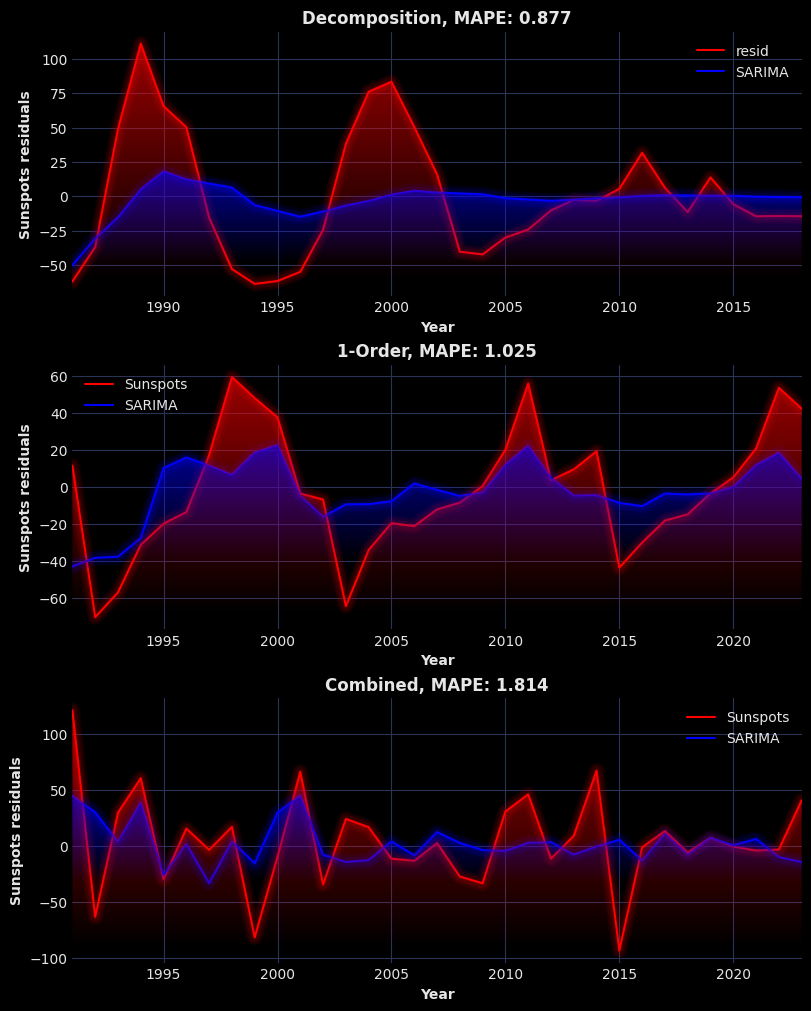

In [255]:
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(3, 1, layout='constrained', figsize=(8, 10))
    for ax, (name, dataset) in zip(figure.axes, sarimax_predictions.items()):
        dataset['test'].plot(ax=ax, color='red')
        dataset['prediction'].plot(ax=ax, color='blue')
        ax.set(xlabel='Year', ylabel='Sunspots residuals', 
               title=f'{name}, MAPE: {dataset["error"]:.3f}')
        ax.legend()
        enhance_plot(figure, ax, glow=True, alpha_gradient=0.6)
figure.savefig('./images/image7.png')

### Fitting other Machine Learning models to the residuals
* Random Forest
* Gradient Boosting
* XGB

In [256]:
def create_lag_features(data: pd.DataFrame, lag: int = 1) -> pd.DataFrame:
    df = pd.DataFrame(data)
    column = df.columns[0]
    for i in range(lag):
        df[f'lag_{i}'] = df[column].shift(i)
    return df.dropna()

In [257]:
ml_predictions = {}
lag_features = 10
rf_params = dict(max_depth=10, min_samples_leaf=1, 
                 min_samples_split=2, n_estimators=20)
gb_params = dict(learning_rate=0.05, max_depth=3, min_samples_leaf=1,
                 min_samples_split=10, n_estimators=1500, subsample=1.0)
xgb_params = dict(colsample_bytree=0.9, learning_rate=0.1, max_depth=4,
                  min_child_weight=4, n_estimators=1500, subsample=0.9, objective='reg:squarederror')
solar_cycles = 4
for data, name in zip(
    [decomposition.resid.dropna(), dataset_month_diff, dataset_month_combined],
    ['Decomposition', '1-Order', 'Combined']
):
    ml_predictions[name] = {}
    lagged_data = create_lag_features(data, lag=lag_features)
    train = lagged_data.iloc[:-132 * solar_cycles]
    test = lagged_data.iloc[-132 * solar_cycles:]
    X_train = train.iloc[:, 1:]
    y_train = train.iloc[:, 0]
    X_test = test.iloc[:, 1:]
    y_test = test.iloc[:, 0]
    for ml_model, ml_params, ml_name in zip(
        [RandomForestRegressor, GradientBoostingRegressor, XGBRegressor],
        [rf_params, gb_params, xgb_params],
        ['RandomForest', 'GradientBoosting', 'XGB']
    ):
        print(f'{name}, {ml_name}')
        model = ml_model(**ml_params)
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        error = mean_absolute_percentage_error(y_test, prediction)
        ml_predictions[name][ml_name] = {'train': y_train,
                                         'test': y_test,
                                         'prediction': prediction,
                                         'error': error}

Decomposition, RandomForest
Decomposition, GradientBoosting
Decomposition, XGB
1-Order, RandomForest
1-Order, GradientBoosting
1-Order, XGB
Combined, RandomForest
Combined, GradientBoosting
Combined, XGB


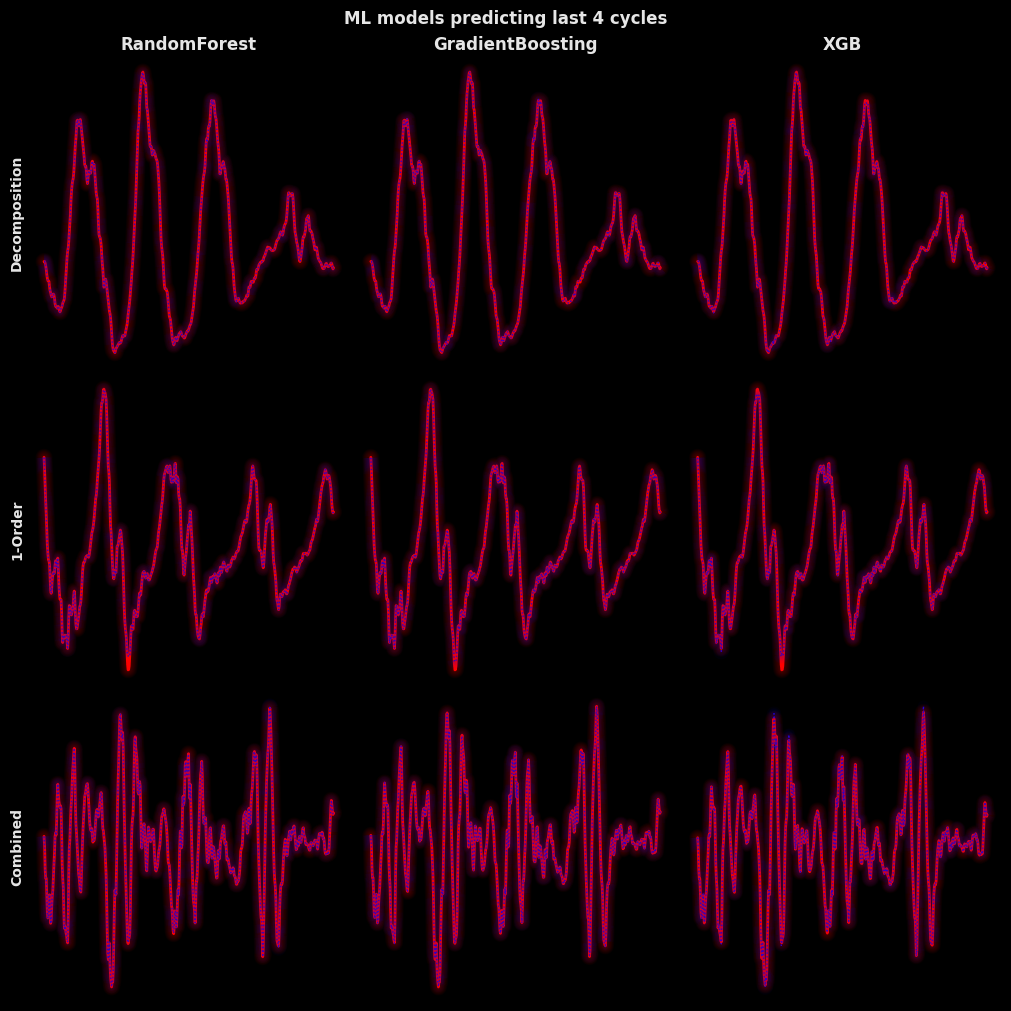

In [261]:
with plt.style.context('cyberpunk'):
    figure, axes = plt.subplots(3, 3, layout='constrained', figsize=(10, 10))
    for i, (name, ml_models) in enumerate(ml_predictions.items()):
        for j, (model_name, model_dict) in enumerate(ml_models.items()):
            y = model_dict['test']
            axes[i, j].plot(y, color='red', linewidth=2)
            
            axes[i, j].plot(y.index, model_dict['prediction'], color='blue', 
                            linestyle=':', linewidth=1)
            axes[i, j].set(xticks=[], yticks=[])
            if i == 0:
                axes[i, j].set(title=f'{model_name}')
            if j == 0:
                axes[i, j].set(ylabel=name)
            enhance_plot(figure, axes[i, j], glow=True)
            axes[i, j].grid()
    figure.suptitle(f'ML models predicting last {solar_cycles} cycles', fontweight='bold')
figure.savefig('./images/image8.png')